In [1]:
import io
import math
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Change directory to scripts folder
directory = os.getcwd().split('/')[-1]

if directory == 'notebooks':
    %cd ..

/Users/mschjolber001/repos/gecco-2023-ambulance-allocation/scripts


In [3]:
# Matplotlib setup
import matplotlib

# matplotlib.use('PDF')

import matplotlib.pyplot as plt
print(f'matplotlib backend: {matplotlib.get_backend()}')

matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
incidents = pd.read_csv('proprietary_data/cleaned_data.csv', index_col=1, parse_dates=True, usecols=['tidspunkt', 'ssbid1000M', 'hastegrad'])
incidents

,hastegrad,ssbid1000M
tidspunkt,,
2015-02-13 09:23:18,A,22640006631000
2015-02-13 14:01:29,A,22420006641000
2015-02-13 13:35:14,V1,22650006640000
2015-02-13 05:09:00,H,22640006652000
2015-02-13 16:00:39,V1,22530006621000
...,...,...
2016-12-14 11:00:00,V1,22690006570000
2017-12-15 09:00:00,V2,23050006671000
2016-11-03 08:00:00,V2,22830006611000


In [5]:
# Filter regions 
oslo = pd.read_csv("data/oslo.csv", encoding="utf-8", index_col=4)
akershus = pd.read_csv("data/akershus.csv", encoding="utf-8", index_col=4)
oslo_and_akershus_data = pd.concat([oslo, akershus])

# Create indices based on SSB grids
oslo_and_akershus = oslo_and_akershus_data.index
df_cells = pd.Index(incidents["ssbid1000M"])

# Filter out all incident cells that are not located in Oslo and Akershus
incidents = incidents[df_cells.isin(oslo_and_akershus)]

incidents = incidents.drop(['ssbid1000M'], axis=1)
incidents

,hastegrad
tidspunkt,
2015-02-13 09:23:18,A
2015-02-13 14:01:29,A
2015-02-13 13:35:14,V1
2015-02-13 05:09:00,H
2015-02-13 16:00:39,V1
...,...
2015-11-02 08:00:00,V2
2017-09-27 10:15:00,V2
2017-12-15 09:00:00,V2


In [6]:
incidents = incidents[incidents.index.year == 2018]
incidents

,hastegrad
tidspunkt,
2018-01-02 09:00:00,V2
2018-01-01 00:18:04,A
2018-01-01 00:18:04,A
2018-01-01 01:01:00,A
2018-01-01 01:55:04,A
...,...
2018-10-12 11:00:00,V2
2018-07-05 10:30:00,V2
2018-09-03 10:30:00,V2


In [7]:
shifts = incidents.groupby(lambda t: 8 < t.hour < 20).value_counts()
shifts

tidspunkt  hastegrad
False      A            26823
           H            25116
           V1            5096
           V2            2555
           V                2
True       A            37201
           H            33828
           V2           11757
           V1           11105
           V                6
dtype: int64

In [8]:
shifts.index = shifts.index.map({
    (False, 'A'): ('night', 'A&H'), 
    (False, 'H'): ('night', 'A&H'),
    (False, 'V1'): ('night', 'V'), 
    (False, 'V2'): ('night', 'V'), 
    (False, 'V'): ('night', 'V'), 

    (True, 'A'): ('day', 'A&H'), 
    (True, 'H'): ('day', 'A&H'),
    (True, 'V1'): ('day', 'V'), 
    (True, 'V2'): ('day', 'V'), 
    (True, 'V'): ('day', 'V'), 
})

shifts = shifts.groupby(['tidspunkt', 'hastegrad']).sum()
shifts

tidspunkt  hastegrad
day        A&H          71029
           V            22868
night      A&H          51939
           V             7653
dtype: int64

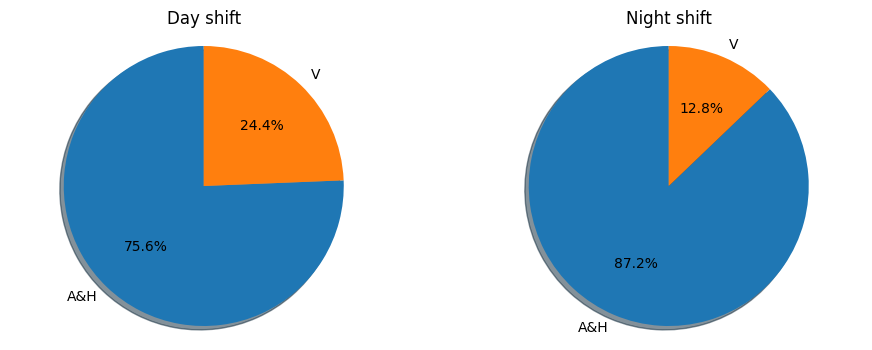

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

labels = shifts['night'].index
sizes_night = shifts['night'].values
sizes_day = shifts['day'].values


ax1.pie(sizes_day, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.set_title('Day shift')
ax1.axis('equal')
ax2.pie(sizes_night, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.set_title('Night shift')
ax2.axis('equal')

plt.show()